## Lab 3: Where is the nearest cafe?

**Objectives:**
   * We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
   * Learn about OSM data stuctures
   * Compute walking distances using just a few lines of code
   * Visualize our data using `folium`

We will be relying heavily on <code>osmnx</code> which is a package that enables automatic download of geospatial data from OSM and allows us to model, project, visualize, and analyze real-world street networks. More information about this package can be found [here](https://osmnx.readthedocs.io/en/stable/) and the [GitHub repo](https://github.com/gboeing/osmnx/tree/6f9236f20a81416bf34186a811a8ebb76afa0dc8)

We will start with a simple example that calculates the Euclidean distance between Condon Hall and some cafes in Eugene. After that, we will use the <code>networkx</code> package to calculate actual walking distances from Condon Hall to the cafes.

### Check for any updates in course materials

Before we start this assignment, we need to check whether there are any updates to the original course repository. We can do this by adding the original repository (the one we forked) as a *remote*. Command line users can do this by running:

<code>git fetch upstream</code>

<code>git merge upstream/master master</code>

GitHub Desktop users should first click the **Fetch origin** button to check for new changes. Then click the triangle symbol next to **Current branch: main**, click **Choose a branch to merge into master**, click **upstream/main** from **Other branches** and click **Create a merge commit**. 

Any new updates to the course repository will now be available in your local repository.

### Create a new environment and launch the notebook

As always, make a new environment that contains all the packages for this lab. Navigate to the `labs/lab3` folder (either from the terminal for Linux and Mac users or from the **CMD.exe Prompt** launched from **Anaconda Navigator** for Windows users) and run:

`conda env create -f environment.yml`

Activate this environment by running:

`conda activate lab3`

Now launch the notebook by running:

`jupyter notebook 03_walking_distances.ipynb`

In [1]:
# Import modules
import osmnx as ox 

import numpy as np
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

### Retrieve OSM data

First we will retrieve all features labelled (or tagged) as buildings in Eugene.

In [2]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

C:\Users\theoh\anaconda3\envs\lab3\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\theoh\anaconda3\envs\lab3\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


It did not take long to download all this data even though this GeoDataFrame is massive (don't worry about the error message!). We can find the number of buildings in Eugene by printing the shape of the GeoDataFrame.

In [3]:
print(gdf.shape)

(55533, 228)


We can find out what attributes are contained in this GeoDataFrame by printing the column headers as a list. 

In [4]:
print(gdf.columns.tolist())

['addr:state', 'building', 'ele', 'gnis:county_id', 'gnis:created', 'gnis:feature_id', 'name', 'operator', 'geometry', 'access', 'wheelchair', 'source', 'ref', 'amenity', 'description', 'opening_hours', 'information', 'tourism', 'addr:city', 'addr:housenumber', 'addr:street', 'brand', 'brand:wikidata', 'brand:wikipedia', 'cuisine', 'takeaway', 'addr:postcode', 'bus', 'network', 'public_transport', 'fee', 'leisure', 'sport', 'material', 'emergency', 'nodes', 'building:levels', 'gnis:county_name', 'internet_access', 'shop', 'url', 'wikidata', 'wikipedia', 'name:ja', 'phone', 'website', 'air_conditioning', 'delivery', 'diet:vegan', 'denomination', 'religion', 'internet_access:fee', 'smoking', 'government', 'office', 'email', 'layer', 'location', 'man_made', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'drive_through', 'short_name', 'boundary', 'heritage', 'heritage:operator', 'nrhp:criteria', 'nrhp:inscription_date', 'nrhp:nhl', 'protection_title', 'ref:nrhp', 'name_1', 

Since OSM is entirely based on volunteered geographic information, there are a lot of attributes, most of which are not complete. We can find the number of non-NaNs in each column by typing:

In [5]:
# Count number of non-NaNs in each column
gdf.count()

addr:state           563
building           55533
ele                   24
gnis:county_id        16
gnis:created          17
                   ...  
yelp                   1
surface                1
ways                  77
type                  77
contact:website        1
Length: 228, dtype: int64

For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [6]:
# Filter cafes
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
cafes

,element_type,osmid,addr:state,building,ele,gnis:county_id,gnis:created,gnis:feature_id,name,operator,...,house:soliciting,soliciting,covered,facebook,opening_hours:url,yelp,surface,ways,type,contact:website
0,way,123376983,NaN,yes,NaN,NaN,NaN,NaN,Latitude 10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,123493968,NaN,yes,NaN,NaN,NaN,NaN,The Human Bean,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,221500325,NaN,retail,NaN,NaN,NaN,NaN,Brail's Expresso,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,244977193,NaN,yes,NaN,NaN,NaN,NaN,TopCity Frozen Yogurt Cafe,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,244983219,NaN,yes,NaN,NaN,NaN,NaN,Starbucks,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,way,277456563,NaN,yes,NaN,NaN,NaN,NaN,Espresso Roma,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,way,283863396,NaN,yes,NaN,NaN,NaN,NaN,Dutch Bros. Coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,way,385083705,NaN,commercial,NaN,NaN,NaN,NaN,Greenleaf Juicing Company,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,way,414520035,NaN,yes,NaN,NaN,NaN,NaN,Romano's,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,way,420982688,NaN,yes,NaN,NaN,NaN,NaN,Voodoo Doughnut,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We find that there are 33 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward. 

### Computing Euclidean distances to cafes from Condon Hall

We now want to compute the distance to ten nearest cafes. First we will have to reproject our data to UTM Zone 10N which is a projection system that contains Oregon (https://epsg.io/32610)

In [7]:
# Reproject to UTM Zone 10N
gdf = gdf.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Find the coordinates of Condon Hall by searching for **Condon Hall** in the original GeoDataFrame.

In [8]:
# Get coordinates of Condon Hall
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

Compute building centroids so we can compute point-to-point distances.

In [9]:
# Get cafe and Condon Hall centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Now we can compute the Euclidean distances between Condon Hall and the cafes

In [10]:
# Compute distances
condon_hall_x = condon_hall['centroid'].x.values[0]
condon_hall_y = condon_hall['centroid'].y.values[0]
distances = np.sqrt(((condon_hall_x - cafes['centroid'].x.values)**2)
                     + ((condon_hall_y - cafes['centroid'].y.values)**2))

# Add to GeoDataFrame
cafes['euclidean_distance'] = distances

...and print a list of the ten closest cafes to Condon Hall

In [11]:
print(cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                         name  euclidean_distance
7   Greenleaf Juicing Company           53.254590
5               Espresso Roma          135.286656
10         Dutch Bros. Coffee          830.863412
16            The Rabbit Hole          994.588162
4                   Starbucks         1094.039455
2            Brail's Expresso         1225.004530
9             Voodoo Doughnut         1240.194485
15              Amazon Coffee         1296.503685
33                  Cafe Yumm         1335.694760
34          Magpie Coffeeshop         1349.524658


Now for a bit of magic, let's visualize our data using `folium`

In [12]:
# Make a new DataFrame containing only the three most relevant columns
nearest_cafes = cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_cafes = nearest_cafes.set_geometry('centroid')

# Convert back to WGS84
nearest_cafes = nearest_cafes.to_crs('EPSG:4326')

# Import package
import folium

# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_cafes.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_cafes.iloc[i]['name'], nearest_cafes.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_cafes.iloc[i]['centroid'].y, nearest_cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

Click on the markers above and a pop-up should appear showing the name of the cafe and Euclidean distance (in meters) from Condon Hall.

## Question 1 (20 points):
Write a script that:

* Computes the Euclidean distance to another **amenity** of your choosing (HINT: use `gdf['amenity'].unique()` to list the different amenities). Feel free to download OSM buildings from another place and choose a different home' location.


* Makes an interactive map showing where your ten nearest amenities are using `folium`. 

### Computing network distances

Euclidean distances often underestimate the distance between two objects, especially when there are obstacles between the two. So we will now compute some more realistic distances to cafes around Condon Hall. First we will need to import the [<code>networkx</code>](https://networkx.org/) package which will allow us conduct a network analysis. 

In [13]:
# Import module
import networkx as nx

Now we will define the coordinates of Condon Hall and download a walkable street network from OSM. Since the furthest of our ten cafes was 1.5 km away, we will limit our download to 1.6 km.

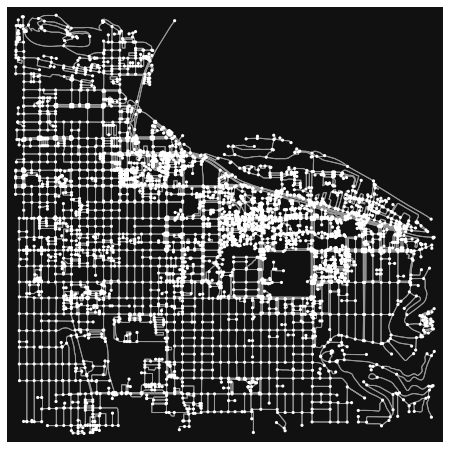

In [14]:
# Define coordinates of Condon Hall
lat_lon = (44.0451, -123.0781)

# Import walkable street network data around Condon Hall
g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [15]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [16]:
# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

# Convert the cafe dataset back to UTM Zone 10N
nearest_cafes = nearest_cafes.to_crs('EPSG:32610')

Coordinate system: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [17]:
# Get x and y coordinates of Condon Hall
orig_xy = (condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the furthest of the ten)
target_xy = (nearest_cafes['centroid'].y.values[-1], nearest_cafes['centroid'].x.values[-1])

In [18]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [19]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [20]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

## Question 2 (20 points): 

Adapt the code above to compute the network distance between two points (either in Eugene or in a city of your choice) and show your results using an interactive map. Write a few sentences about what your map shows.

### Compute network distances between Condon Hall and cafes

In [21]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Print length of route
print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))

Walking distance to Magpie Coffeeshop = 1.7 km


OK that looks very nice, but what about if we wanted distances to all ten cafes. We need to put this code into a for loop.

In [22]:
# Get x and y coordinates of all ten of the nearest cafes
target_xy = (nearest_cafes['centroid'].y.values, nearest_cafes['centroid'].x.values)

In [23]:
routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

Walking distance to Greenleaf Juicing Company = 0.2 km
Walking distance to Espresso Roma = 0.2 km
Walking distance to Dutch Bros. Coffee = 1.1 km
Walking distance to The Rabbit Hole = 1.4 km
Walking distance to Starbucks = 1.2 km
Walking distance to Brail's Expresso = 1.6 km
Walking distance to Voodoo Doughnut = 1.6 km
Walking distance to Amazon Coffee = 1.7 km
Walking distance to Cafe Yumm = 1.6 km
Walking distance to Magpie Coffeeshop = 1.7 km


Let's add the network distances to the original DataFrame and display

In [24]:
nearest_cafes['network_distance'] = distances
nearest_cafes

,name,euclidean_distance,centroid,network_distance
7,Greenleaf Juicing Company,53.254590,POINT (493687.352 4876918.523),247.174277
5,Espresso Roma,135.286656,POINT (493611.648 4876951.376),161.243737
10,Dutch Bros. Coffee,830.863412,POINT (492960.549 4877198.252),1052.307907
16,The Rabbit Hole,994.588162,POINT (492850.333 4876428.444),1440.216260
4,Starbucks,1094.039455,POINT (494822.753 4876971.001),1201.418448
2,Brail's Expresso,1225.004530,POINT (492582.859 4876464.165),1597.013736
9,Voodoo Doughnut,1240.194485,POINT (492600.931 4877398.340),1563.651558
15,Amazon Coffee,1296.503685,POINT (492548.799 4876358.612),1685.991135
33,Cafe Yumm,1335.694760,POINT (492787.786 4877834.123),1573.524300
34,Magpie Coffeeshop,1349.524658,POINT (492744.388 4877809.091),1655.870230


## Question 3 (10 points): 


* a) Calculate the average difference between the Euclidean and network distances for you amenities 


* b) Describe some situations where it would not be advisable to use Euclidean distances?

## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**